In [114]:
from scipy import spatial
import gensim.downloader as api
from sklearn.decomposition import PCA
import torch
import torch.nn as nn
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
import seaborn as sns
from seaborn.colors import crayons
from sklearn.metrics.pairwise import paired_cosine_distances,cosine_distances
import scipy as sp
from sklearn.utils.extmath import stable_cumsum
from sentence_transformers import SentenceTransformer
import tqdm
import plotly.express as px
import torch
from torcheval.metrics.functional import multiclass_confusion_matrix
from torch.optim.lr_scheduler import StepLR

<h1>Toolbox</h1>

In [2]:
def z(x):
    n = x.shape[0]
    mean = torch.sum(x,dim=0)/n # X.mean()
    std = torch.std(x,dim=0)
    z_scores = (x - mean)/std
    return z_scores

<h1>Data</h1>

384-length embeddings

Okay, we're going to take an even training shuffle first of 1000 of each, and then test on the last 89 unseen, along with 89 unseen of implicit, and 89 not hate. 

In [3]:
data1 = pd.read_csv("/Users/temp/Documents/Spring 2024/NLP/mmontgomery1-master/project/implicit-hate-corpus/implicit_hate_v1_stg1_posts.tsv",sep="\t")
vecs = []
sbert384 = SentenceTransformer("all-MiniLM-L6-v2")
embeddings = sbert384.encode(data1['post'])
for i in range(384):
    data1['v_'+str(i)] = [j[i] for j in embeddings]
    vecs.append("v_"+str(i))

/var/folders/4z/bnyz3w2s6lg97h_fm4lt5ksr0000gn/T/ipykernel_1280/165316287.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data1['v_'+str(i)] = [j[i] for j in embeddings]
/var/folders/4z/bnyz3w2s6lg97h_fm4lt5ksr0000gn/T/ipykernel_1280/165316287.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data1['v_'+str(i)] = [j[i] for j in embeddings]
/var/folders/4z/bnyz3w2s6lg97h_fm4lt5ksr0000gn/T/ipykernel_1280/165316287.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` 

3-length embeddings

In [4]:
df = pd.read_csv("/Users/temp/Documents/Spring 2024/NLP/mmontgomery1-master/project/implicit-hate-corpus/implicit_hate_v1_stg1_posts.tsv",sep="\t")
sbert3 = sbert3 = SentenceTransformer("all-MiniLM-L6-v2",truncate_dim=3)
embeddings = sbert3.encode(df['post'],show_progress_bar=True)
for i in range(3):
    df['v_'+str(i)] = [j[i] for j in embeddings]

Batches:   0%|          | 0/672 [00:00<?, ?it/s]

<h1>Visualizing the raw 384</h1>

In [5]:
"""fig = px.scatter_3d(df, x='v_0', y='v_1', z='v_2',
                    color='class',size_max=.01,opacity=0.4)
fig.show()"""

"fig = px.scatter_3d(df, x='v_0', y='v_1', z='v_2',\n                    color='class',size_max=.01,opacity=0.4)\nfig.show()"

<h1>Assembling Even Testing and Training Sets</h1>

In [6]:
nh = data1.loc[data1['class']=='not_hate'][:1000]
eh = data1.loc[data1['class']=='explicit_hate'][:1000]
ih = data1.loc[data1['class']=='implicit_hate'][:1000]
train_data1 = pd.concat([nh,eh,ih])
nh2 = data1.loc[data1['class']=='not_hate'][1001:1089]
eh2 = data1.loc[data1['class']=='explicit_hate'][1001:1089]
ih2 = data1.loc[data1['class']=='implicit_hate'][1001:1089]
test_data1 = pd.concat([nh2,eh2,ih2])

In [74]:
train_data1 = train_data1.sample(frac=1)

<h1>Classifying Model</h1>

In [200]:
class IDHate_simple(nn.Module):
    def __init__(self):
        super(IDHate_simple,self).__init__()
        self.softmax = nn.Softmax(dim=0)#Need this for the probabilities at the end
        self.sigmoid = nn.Sigmoid()#Need this to normalize at each layer
        self.tanh = nn.Tanh()#Need this for weights; want to be able to weight a component but in a way that doesn't affect the classification
        self.W = nn.Parameter(torch.zeros((384,3),dtype=torch.float64),requires_grad=True)#used to make X-based weights
        self.S = torch.zeros((1,3),requires_grad=False,dtype=torch.float64)
        self.labels = ['implicit_hate', 'not_hate', 'explicit_hate']
        self.output = torch.zeros((1,3))
        return
    
    def forward(self,x):        
        self.S= x @ self.W
        self.output = self.softmax(self.S)
        return self.output,self.S

    def _print(self):
        print("W","\n",self.W)
        print("S","\n",self.S)
        print("p","\n",self.output)
        return
    def _train(self,data,epochs,learning_rate):
        criterion = nn.CrossEntropyLoss()
        torch.random.manual_seed(42)  
        np.random.seed(42)
        optimizer = torch.optim.Adam(self.parameters(),
                                        lr=learning_rate)
        sched = StepLR(optimizer,gamma=0.3,step_size=100)
        loss_val = []
        # main training loop
        for epoch in range(epochs):
            optimizer.zero_grad()
            np.random.shuffle(data)
            losses = []
            for batch, (X, y) in enumerate(data[:300]):
                #print(y)
                result = self.forward(X)
                loss = criterion(result[0],y)
                loss.backward()      # computes all the gradients
                optimizer.step()
                losses.append(loss.item())
            loss_val.append(np.mean(losses))
            sched.step()
        plt.figure()
        plt.plot(loss_val, '-')
        plt.ylabel('loss')
        plt.xlabel('epoch')
        plt.show()
        return loss_val
            

Training

In [197]:
train_X1 = torch.tensor(train_data1[vecs].to_numpy(),dtype=torch.float64)
train_X1 = z(train_X1)
train_Y1 = []
for c in train_data1['class']:
    y_hot = [0,0,0]
    y_hot[int(['implicit_hate', 'not_hate', 'explicit_hate'].index(c))] = 1
    y_hot = torch.tensor(y_hot,dtype=torch.float64)
    train_Y1.append(y_hot)
m1train_data1 = list(zip(train_X1,train_Y1))

test_X1 = torch.tensor(test_data1[vecs].to_numpy(),dtype=torch.float64)
test_X1 = z(test_X1)
test_Y1 = []
for c in test_data1['class']:
    y_hot = [0,0,0]
    y_hot[int(['implicit_hate', 'not_hate', 'explicit_hate'].index(c))] = 1
    y_hot = torch.tensor(y_hot,dtype=torch.float64)
    test_Y1.append(y_hot)
m1test_data1 = list(zip(test_X1,test_Y1))

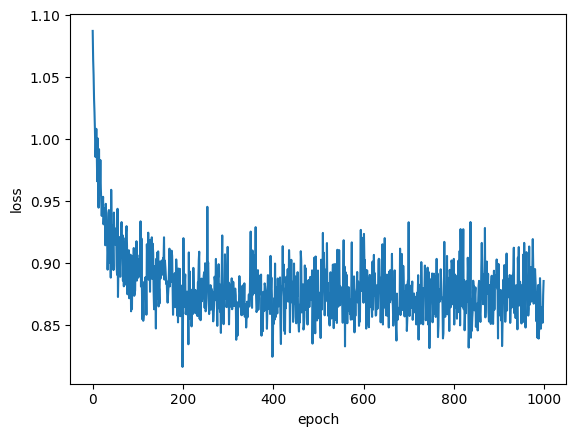

In [201]:
model = IDHate_simple()
loss = model._train(m1train_data1,1000, 0.00001)

Testing

In [202]:
correct = 0
s1csmart = []
s2csmart = []
s3csmart = []
actual = []
pred = []
for x,y in m1test_data1:
    results = model(x)
    if int(torch.argmax(results[0])) == list(y).index(1):
        correct+=1
    s1csmart.append(results[1][0].item())
    s2csmart.append(results[1][1].item())
    s3csmart.append(results[1][2].item())
    actual.append(list(y).index(1))
    pred.append(torch.argmax(results[0]))
print("trained",correct)
stupid_model=IDHate_simple()
correct = 0
#test_data1 = train_data1[:500]
for x,y in m1test_data1:
    results = stupid_model(x)
    if int(torch.argmax(results[0])) == list(y).index(1):
        correct+=1
print("untrained",correct)

trained 170
untrained 88


In [204]:
cdfsmart = pd.DataFrame()
cdfsmart['v_1'] = s1csmart
cdfsmart['v_2'] = s2csmart
cdfsmart['v_3'] = s3csmart
cdfsmart['actual'] = actual
fig = px.scatter_3d(cdfsmart, x='v_1', y='v_2', z='v_3',
                    color='actual',size_max=.01,opacity=0.4)
fig.show()

In [205]:
multiclass_confusion_matrix(torch.tensor(pred,dtype=torch.int64),torch.tensor(actual,dtype=torch.int64),3)

tensor([[52, 21, 15],
        [22, 54, 12],
        [ 4, 20, 64]])

<h1>Regression-ish Style</h1>

In [228]:
lindict = dict(zip(['not_hate','implicit_hate', 'explicit_hate'],[0,1,2]))

In [229]:
train_X1 = torch.tensor(train_data1[vecs].to_numpy(),dtype=torch.float64)
train_X1 = torch.tensor(z(train_X1),dtype=torch.float64)
train_data1['lin_label'] = [lindict[e] for e in train_data1['class']]
train_Y1 = torch.tensor(train_data1['lin_label'].to_numpy(),dtype=torch.float64)
m2train_data1 = list(zip(train_X1,train_Y1))

test_X1 = torch.tensor(test_data1[vecs].to_numpy(),dtype=torch.float64)
test_X1 = torch.tensor(z(test_X1),dtype=torch.float64)
test_data1['lin_label'] = [lindict[e] for e in test_data1['class']]
test_Y1 = torch.tensor(test_data1['lin_label'].to_numpy(),dtype=torch.float64)
m2test_data1 = list(zip(test_X1,test_Y1))

/var/folders/4z/bnyz3w2s6lg97h_fm4lt5ksr0000gn/T/ipykernel_1280/3850033164.py:2: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).

/var/folders/4z/bnyz3w2s6lg97h_fm4lt5ksr0000gn/T/ipykernel_1280/3850033164.py:8: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).



In [230]:
len(m2test_data1)

264

Regression 1pc

In [231]:
class RegressHate_1_notworking(nn.Module):
    def __init__(self):
        super(RegressHate_1_notworking,self).__init__()
        self.linear = nn.Linear(384,1)
        self.linear.weight = torch.nn.Parameter(torch.zeros((1,384),dtype=torch.float64,requires_grad=True))
        self.linear.bias = torch.nn.Parameter(torch.tensor([0],dtype=torch.float64,requires_grad=True))
        self.labels = ['not_hate','implicit_hate','explicit_hate']
        self.diff = []
        self.output = []
        return
    
    def forward(self,x):   
        self.output = self.linear(x)
        return self.output
    def score2class(self,a):
        self.diff = torch.abs(torch.subtract(torch.tensor([0,1,2],dtype=torch.float64),torch.tensor([a,a,a],dtype=torch.float64)))
        #print(self.diff)
        return self.labels[torch.argmin(self.diff)]

    def _print(self):
        print("W","\n",self.linear.weight)
        print("p","\n",self.output)
        return
    
    def _train(self,data,epochs,learning_rate):
        criterion = nn.MSELoss()
        torch.random.manual_seed(42)  
        np.random.seed(42)
        optimizer = torch.optim.Adam(model.parameters(),
                                        lr=learning_rate)
        sched = StepLR(optimizer,gamma=0.3,step_size=100)
        loss_avg = []
        # main training loop
        for epoch in range(epochs):
            np.random.shuffle(data)
            loss_val=[]
            #self._print()
            for batch, (X, y) in enumerate(data[:300]):
                #print(y)
                result = model.forward(X)
                loss = criterion(result,y)
                optimizer.zero_grad()
                loss_val.append(loss.item())
                loss.backward()
                optimizer.step()
            loss_avg.append(np.mean(loss_val))
            sched.step()
            
        plt.figure()
        plt.plot(loss_avg, '-')
        plt.ylabel('loss')
        plt.xlabel('epoch')
        plt.show()
        return loss_avg
            

Training

/Users/temp/Library/Python/3.9/lib/python/site-packages/torch/nn/modules/loss.py:535: UserWarning:

Using a target size (torch.Size([])) that is different to the input size (torch.Size([1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.



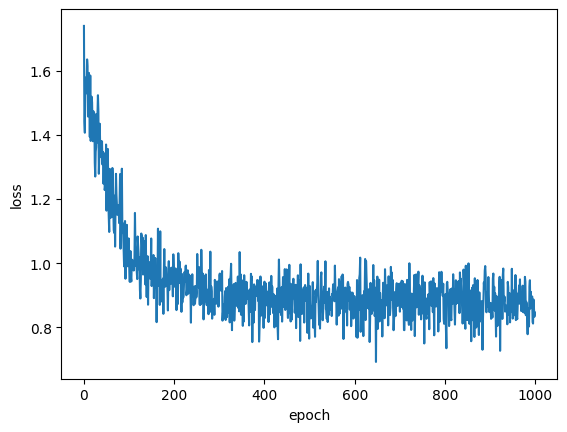

In [232]:
model = RegressHate_1_notworking()
loss = model._train(m2train_data1,1000, 0.00001)

Testing

In [233]:
lindict_rev = dict([(l[1],l[0]) for l in lindict.items()])

In [234]:
lindict_rev

{0: 'not_hate', 1: 'implicit_hate', 2: 'explicit_hate'}

In [235]:
correct = 0
scoresmart = []
ysmart = []
predicted = []
actual_labelsmart = []
for x,y in m2test_data1:
    score = model.forward(x)
    results = model.score2class(score.item())
    if results == lindict_rev[y.item()]:
        correct+=1
    scoresmart.append(score.item())
    ysmart.append(y.item())
    actual_labelsmart.append(lindict_rev[(y.item())])
    predicted.append(results)
print('trained', correct)

stupid_model = RegressHate_1_notworking()
correct = 0
scorestupid = []
ystupid = []
actual_labelstupid = []
for x,y in m2test_data1:
    score = stupid_model.forward(x)
    results = stupid_model.score2class(score.item())
    if results == lindict_rev[y.item()]:
        correct+=1
    scorestupid.append(score.item())
    ystupid.append(y.item())
    actual_labelstupid.append(lindict_rev[y.item()])
print("untrained",correct)

trained 99
untrained 88


In [236]:
rdfsmart = pd.DataFrame()
rdfsmart['predicted'] = scoresmart
rdfsmart['actual'] = ysmart
rdfsmart['color'] = actual_labelsmart
fig = px.scatter(rdfsmart, x='predicted', y='actual',
                    color='color',size_max=.01,opacity=0.4)
fig.show()

/Users/temp/Library/Python/3.9/lib/python/site-packages/plotly/express/_core.py:1980: FutureWarning:

When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.



In [237]:
rdfstupid = pd.DataFrame()
rdfstupid['predicted'] = scorestupid
rdfstupid['actual'] = ystupid
rdfstupid['color'] = actual_labelstupid
fig = px.scatter(rdfstupid, x='predicted', y='actual',
                    color='color',size_max=.01,opacity=0.4)
fig.show()

/Users/temp/Library/Python/3.9/lib/python/site-packages/plotly/express/_core.py:1980: FutureWarning:

When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.



In [238]:
print(model.linear.bias)

Parameter containing:
tensor([0.3261], dtype=torch.float64, requires_grad=True)


In [239]:
rdfsmart['pred_num'] = [(lindict[y]) for y in predicted]
rdfsmart.value_counts(["actual","pred_num"])

actual  pred_num
0.0     0           78
1.0     0           68
2.0     1           52
        0           35
1.0     1           20
0.0     1           10
2.0     2            1
Name: count, dtype: int64

In [240]:
multiclass_confusion_matrix(torch.tensor([(lindict[y]) for y in predicted],dtype=torch.int64),torch.tensor([(y) for y in ysmart],dtype=torch.int64),3)

/var/folders/4z/bnyz3w2s6lg97h_fm4lt5ksr0000gn/T/ipykernel_1280/2638514855.py:1: DeprecationWarning:

an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.



tensor([[78, 10,  0],
        [68, 20,  0],
        [35, 52,  1]])

<h3>2-pc regression</h3>

In [241]:
class Hate2pc_Lin(nn.Module):
    def __init__(self):
        super(Hate2pc_Lin,self).__init__()
        self.linear1 = nn.Linear(384,1)
        self.linear1.weight = torch.nn.Parameter(torch.zeros((1,384),dtype=torch.float64,requires_grad=True))
        self.linear1.bias = torch.nn.Parameter(torch.tensor([0],dtype=torch.float64,requires_grad=True))

        self.linear2 = nn.Linear(384,1)
        self.linear2.weight = torch.nn.Parameter(torch.zeros((1,384),dtype=torch.float64,requires_grad=True))
        self.linear2.bias = torch.nn.Parameter(torch.tensor([0],dtype=torch.float64,requires_grad=True))
        
        self.hate = torch.tensor([1],dtype=torch.float64,requires_grad=True)
        self.nothate = torch.tensor([1],dtype=torch.float64,requires_grad=True)
        self.S = torch.tensor([1],dtype=torch.float64,requires_grad=True)

        self.labels = ['not_hate','implicit_hate','explicit_hate']
        self.diff = []
        self.output = torch.tensor([1],dtype=torch.float64,requires_grad=True)
        return
    
    def forward(self,x):        
        self.hate = self.linear1(x)
        self.nothate = self.linear2(x)
        self.S = torch.subtract(self.hate,self.nothate)
        
        return self.S,self.nothate,self.hate

    def score2class(self,y):
        self.diff = torch.abs(torch.subtract(torch.tensor([0,1,2],dtype=torch.float64),torch.tensor([y,y,y],dtype=torch.float64)))
        return self.labels[torch.argmin(self.diff)]
    
    def _print(self):
        print("W1","\n",self.linear1.weight)
        print("W2","\n",self.linear2.weight)
        print("S","\n",self.S)
        print("hate","\n",self.hate)
        print("not hate","\n",self.nothate)
        return
    def _train(self,data,epochs,learning_rate):
        criterion = nn.MSELoss()
        torch.random.manual_seed(42)  
        np.random.seed(42)
        optimizer = torch.optim.Adam(self.parameters(),
                                        lr=learning_rate)
        sched = StepLR(optimizer,gamma=0.3,step_size=100)
        loss_val = []
        # main training loop
        for epoch in range(epochs):
            np.random.shuffle(data)
            #self._print()
            losses = []
            for batch, (X, y) in enumerate(data[:300]):
                #print(y)
                result = self.forward(X)
                loss = criterion(result[0],y)
                optimizer.zero_grad()
                loss.backward()      # computes all the gradients
                optimizer.step()
                losses.append(loss.item())
            loss_val.append(np.mean(losses))
            sched.step()
        plt.figure()
        plt.plot(loss_val, '-')
        plt.ylabel('loss')
        plt.xlabel('epoch')
        plt.show()
        return loss_val
            

/Users/temp/Library/Python/3.9/lib/python/site-packages/torch/nn/modules/loss.py:535: UserWarning:

Using a target size (torch.Size([])) that is different to the input size (torch.Size([1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.



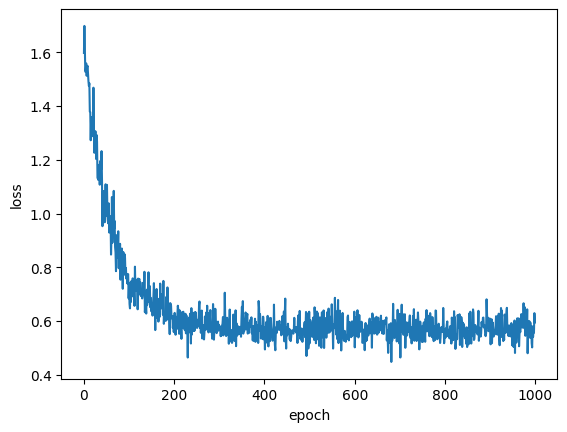

In [242]:
model = Hate2pc_Lin()
loss = model._train(m2train_data1,1000, 0.00001)

In [243]:
correct = 0
scoresmart = []
predicted = []
actual = []
d1 = []
d2 = []
for x,y in m2test_data1:
    score = model.forward(x)
    results = model.score2class(score[0].item())
    if results == lindict_rev[y.item()]:
        correct+=1
    scoresmart.append(score[0].item())
    actual.append(model.score2class(y.item()))
    predicted.append(results)
    d1.append(score[1].item())
    d2.append(score[2].item())

print("trained",correct)

stupid_model = RegressHate_1_notworking()
correct = 0
scorestupid = []
ystupid = []
resultstupid = []
for x,y in m2test_data1:
    score = stupid_model.forward(x)
    result = stupid_model.score2class(score.item())
    if result == lindict_rev[y.item()]:
        correct+=1
    scorestupid.append(score.item())
    ystupid.append(y.item())
    actual_labelstupid.append(lindict_rev[y.item()])
print("untrained",correct)

trained 133
untrained 88


In [244]:
df2pc = pd.DataFrame()
df2pc['d1'] = d1
df2pc['d2'] = d2
df2pc['actual'] = actual
df2pc['predicted'] = predicted

In [245]:
fig = px.scatter(df2pc, x='d1', y='d2',
                    color='actual',size_max=.01,opacity=0.4)
fig.show()

/Users/temp/Library/Python/3.9/lib/python/site-packages/plotly/express/_core.py:1980: FutureWarning:

When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.



In [246]:
fig = px.scatter(df2pc, x='d1', y='d2',
                    color='predicted',size_max=.01,opacity=0.4)
fig.show()

/Users/temp/Library/Python/3.9/lib/python/site-packages/plotly/express/_core.py:1980: FutureWarning:

When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.



In [247]:
print(model.linear1.bias,model.linear2.bias)

Parameter containing:
tensor([0.2969], dtype=torch.float64, requires_grad=True) Parameter containing:
tensor([-0.2969], dtype=torch.float64, requires_grad=True)


In [248]:
multiclass_confusion_matrix(torch.tensor([lindict[y] for y in actual],dtype=torch.int64),torch.tensor([lindict[y] for y in predicted],dtype=torch.int64),3)

tensor([[64, 35, 14],
        [24, 53, 58],
        [ 0,  0, 16]])